# wslfp

This is a lightweight package for computing the LFP proxy from [Mazzoni, Lindén et al., 2015](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004584). 


## Installation
Simply install from pypi:
```bash
pip install wslfp
```

## Usage

### Point neuron network simulation

<details>
<summary>Click to expand!</summary>

This is where you put your content that you want to be collapsible.

</details>


In [1]:
import brian2.only as b2
import matplotlib.pyplot as plt
import numpy as np

b2.prefs.codegen.target = "numpy"
b2.seed(18470724)
rng = np.random.default_rng(18470724)

First we need a point neuron simulation to approximate the LFP for.
We'll use a balanced E/I network implementation [from the Neuronal Dynamics textbook](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network).
Note that we record synaptic currents only from pyramidal cells, since contributions from interneurons are insignificant.

🚧 TODO: get currents from external input as well

In [2]:
N_excit = 800
N_inhib = None  # None = N_excit / 4
N_extern = 1000
connection_probability = 0.1
# w0 = 0.1 * b2.mV
w0 = 0.07 * b2.nA
g = 4
synaptic_delay = 1.5 * b2.ms
# poisson_input_rate = 13 * b2.Hz
poisson_input_rate = 9 * b2.Hz
# w_external = None
w_external = 0.1 * b2.mV
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
membrane_time_scale = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms
random_vm_init = True

if N_inhib is None:
    N_inhib = int(N_excit / 4)
N_tot = N_excit + N_inhib
if N_extern is None:
    N_extern = int(N_excit * connection_probability)
if w_external is None:
    w_external = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
    dv/dt = (-(v-v_rest) + Rm*(I_ampa + I_gaba)) / membrane_time_scale : volt (unless refractory)
    I_ampa : amp
    I_gaba : amp
"""

syn_eqs = """
    dI_syn_syn/dt = (s - I_syn)/tau_dsyn : amp
    I_syn_post = I_syn_syn : amp (summed)
    ds/dt = -s/tau_rsyn : amp
"""

neurons = b2.NeuronGroup(
    N_tot,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
if random_vm_init:
    neurons.v = (
        np.random.uniform(
            v_rest / b2.mV, high=firing_threshold / b2.mV, size=(N_excit + N_inhib)
        )
        * b2.mV
    )
else:
    neurons.v = v_rest
excitatory_population = neurons[:N_excit]
inhibitory_population = neurons[N_excit:]

exc_synapses = b2.Synapses(
    excitatory_population,
    target=neurons,
    model="""
        dI_syn_syn/dt = (s - I_syn_syn)/tau_dsyn : amp
        I_ampa_post = I_syn_syn : amp (summed)
        ds/dt = -s/tau_rsyn : amp
    """,
    on_pre="s += J_excit",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms},
)
exc_synapses.connect(p=connection_probability)

inhib_synapses = b2.Synapses(
    inhibitory_population,
    target=neurons,
    model="""
        dI_syn_syn/dt = (s - I_syn_syn)/tau_dsyn : amp
        I_gaba_post = I_syn_syn : amp (summed)
        ds/dt = -s/tau_rsyn : amp
    """,
    on_pre="s += J_inhib",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.25 * b2.ms, "tau_dsyn": 5 * b2.ms},
)
inhib_synapses.connect(p=connection_probability)

external_poisson_input = b2.PoissonInput(
    target=neurons,
    target_var="v",
    N=N_extern,
    rate=poisson_input_rate,
    weight=w_external,
)

spike_monitor = b2.SpikeMonitor(neurons, record=True)
current_monitor = b2.StateMonitor(neurons, ["I_ampa", "I_gaba"], record=range(N_excit))

net = b2.Network(
    neurons,
    exc_synapses,
    inhib_synapses,
    external_poisson_input,
    spike_monitor,
    current_monitor,
)

net.run(0.5 * b2.second)

INFO       The synaptic equation for the variable I_syn_syn does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable s does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]


INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.25s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.12s). [brian2.stateupdaters.base.method_choice]


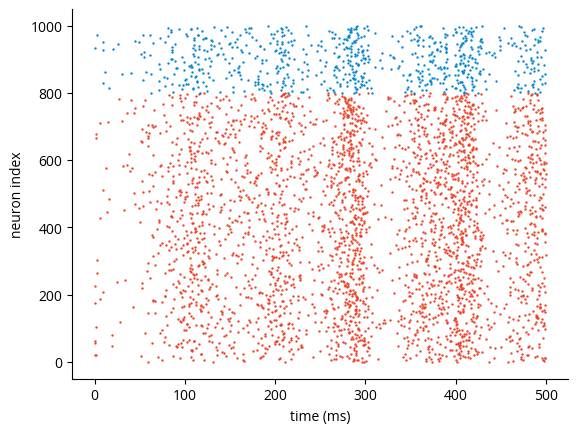

In [3]:
fig, ax = plt.subplots()
c_exc = "xkcd:tomato"
c_inh = "xkcd:cerulean"
t_spk_exc = spike_monitor.t[spike_monitor.i < N_excit] / b2.ms
i_spk_exc = spike_monitor.i[spike_monitor.i < N_excit]
t_spk_inh = spike_monitor.t[spike_monitor.i >= N_excit] / b2.ms
i_spk_inh = spike_monitor.i[spike_monitor.i >= N_excit]
ax.scatter(t_spk_exc, i_spk_exc, s=0.5, c=c_exc)
ax.scatter(t_spk_inh, i_spk_inh, s=0.5, c=c_inh)
ax.set(xlabel="time (ms)", ylabel="neuron index");

Let's give our neurons coordinates in space and choose recording sites.
Again, since only synaptic currents onto pyramidal cells contribute significantly to LFP, we'll ignore interneurons.

In [4]:
exc_coords = rng.uniform(-250, 250, (N_excit, 3))
exc_coords[:5]

array([[ 104.6606786 ,  205.54732892, -148.12166896],
       [ -43.94925826,  -10.14448589,  241.31175062],
       [-210.4378934 ,   93.42302493,  148.58298887],
       [ 206.65832644,   24.76391578,  213.96022925],
       [  66.21804613,   77.7437387 ,   32.07423479]])

In [25]:
rec_radii = np.array([0, 250, 500])
elec_coords = np.meshgrid(rec_radii, [0], np.linspace(-400, 600, 10))
elec_coords = np.column_stack([a.flatten() for a in elec_coords])
elec_coords[0:10]

array([[   0.        ,    0.        , -400.        ],
       [   0.        ,    0.        , -288.88888889],
       [   0.        ,    0.        , -177.77777778],
       [   0.        ,    0.        ,  -66.66666667],
       [   0.        ,    0.        ,   44.44444444],
       [   0.        ,    0.        ,  155.55555556],
       [   0.        ,    0.        ,  266.66666667],
       [   0.        ,    0.        ,  377.77777778],
       [   0.        ,    0.        ,  488.88888889],
       [   0.        ,    0.        ,  600.        ]])

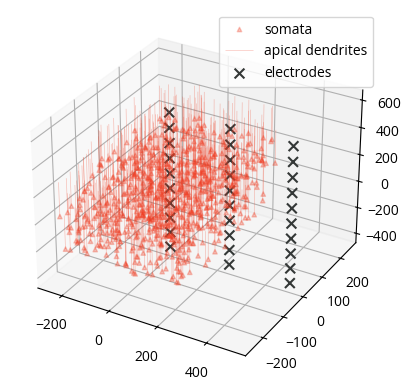

In [6]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
apex_coords = exc_coords + [0, 0, 250]
ax.scatter(*exc_coords.T, marker="^", color=c_exc, label="somata", alpha=0.3, s=10)
apical_dendrites = np.stack([exc_coords, apex_coords], axis=1)
assert apical_dendrites.shape == (N_excit, 2, 3)

# The most efficient way to plot multiple lines at once:
lines = Line3DCollection(
    apical_dendrites, color=c_exc, alpha=0.3, label="apical dendrites", linewidth=0.5
)
ax.add_collection(lines)

ax.scatter(
    *elec_coords.T, marker="x", alpha=1, s=50, color="xkcd:charcoal", label="electrodes"
)
ax.legend()

Now we initialize a `WSLFP` object which stores the contributions from each source to the total LFP.
We can either follow Mazzoni, Linden *et al.*'s original approach of aggregating currents over the whole population, or treat each neuron as its own source.
The `WSLFP` computes relative coordinates between electrodes and current sources and stores the amplitude contribution of each source to the total signal.
Different amplitude profiles are available:
- `mazzoni15`: derived from [Fig. 2B of the original paper](https://doi.org/10.1371/journal.pcbi.1004584.g002).
    The most accurate option since it was based on detailed simulations.
    It is most appropriate when each source represents a population of neurons since that is how the data was produced.
- `mazzoni15_single`: has the same shape as `mazzoni15`, but is optimally shrunk so that the profile of individual neurons averaged out over a 250 μm-radius cylinder produces the population profile.
- `aussel18`: uses the equation for contributions from individual neurons as described in [Aussel *et al.*, 2018](https://doi.org/10.1007/s10827-018-0704-x).

For a detailed comparison, see [`amplitude_comparison.ipynb`](./amplitude_comparison.ipynb).


In [7]:
import wslfp

wslfp_computer = wslfp.WSLFP.from_xyz_coords(
    elec_coords, exc_coords, amp_func=wslfp.amplitude.aussel18
)
wslfp_computer_pop = wslfp.WSLFP.from_xyz_coords(
    elec_coords, exc_coords.mean(axis=0), amp_func=wslfp.amplitude.mazzoni15
)

We then compute the LFP signal from the synaptic currents we recorded during the simulation.
For demonstration purposes, we use again use both the population and per-neuron versions:

In [30]:
t_ms = current_monitor.t / b2.ms
lfp = wslfp_computer.compute(
    t_ms, t_ms, current_monitor.I_ampa.T, t_ms, current_monitor.I_gaba.T
)

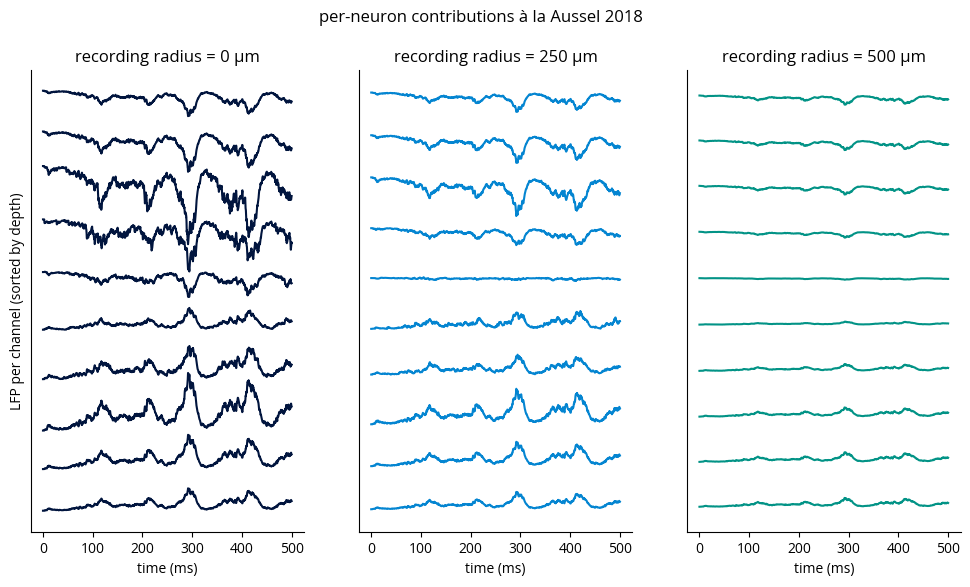

In [34]:
def plot_lfp(lfp, title=None):
    n_shanks = 3
    n_contacts_per_shank = 10
    fig, axs = plt.subplots(1, n_shanks, sharey=True, figsize=(12, 6))
    for i, color, r_rec, ax in zip(
        range(n_shanks), ["xkcd:navy", "xkcd:cerulean", "xkcd:teal"], rec_radii, axs
    ):
        lfp_for_shank = lfp[
            :, i * n_contacts_per_shank : (i + 1) * n_contacts_per_shank
        ]
        ax.plot(
            t_ms,
            lfp_for_shank + np.arange(n_contacts_per_shank) * 1.1 * np.abs(lfp.max()),
            c=color,
        )
        ax.set(xlabel="time (ms)", yticks=[], title=f"recording radius = {r_rec} µm")

    axs[0].set(ylabel="LFP per channel (sorted by depth)")
    if title:
        fig.suptitle(title)


plot_lfp(lfp, "per-neuron contributions à la Aussel 2018")

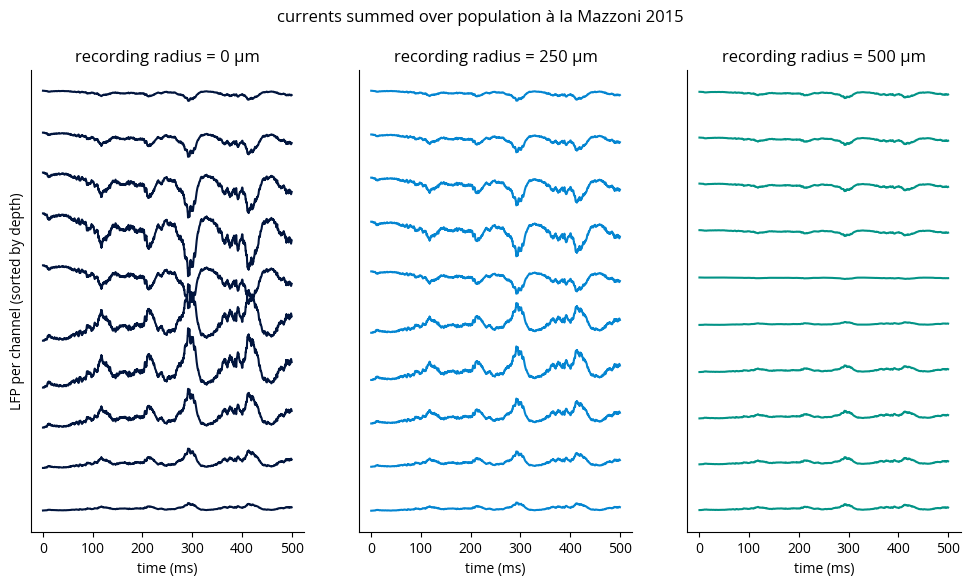

In [36]:
lfp_pop = wslfp_computer_pop.compute(
    t_ms,
    t_ms,
    current_monitor.I_ampa.sum(axis=0),
    t_ms,
    current_monitor.I_gaba.sum(axis=0),
)
plot_lfp(lfp_pop, title="currents summed over population à la Mazzoni 2015")

In [49]:
print(len(exc_synapses.j))
print(exc_synapses.N)
# we have as many synapses as expected. Is the number of spikes right?
print(np.mean(exc_synapses.N_outgoing))
print(len(t_spk_exc))
len(t_spk_exc) * np.mean(exc_synapses.N_outgoing)

80638
<synapses.N: 80638>
101.6963218333788
2999


304987.269178303

## Computing from spikes
`wslfp` provides functions to generate synaptic currents from spikes to avoid having to simulate synaptic dynamics.
Let's compare the results with those above; they should be identical since we convolve the spikes with the exact same postsynaptic current kernels as those simulated as ODEs with Brian (see [`postsynaptic_currents.ipynb`](./postsynaptic_currents.ipynb) for more background).

In [55]:
# connection matrices can be big; use a sparse matrix to save memory
from scipy import sparse

J = sparse.lil_array((N_tot, N_tot))
J[exc_synapses.i, exc_synapses.j] = J_excit
J[inhib_synapses.i, inhib_synapses.j] = J_inhib
J = J.tocsr()

I_ampa = wslfp.spikes_to_biexp_currents(t_ms, t_spk_exc, i_spk_exc, J, 2, 0.4)
I_gaba = wslfp.spikes_to_biexp_currents(t_ms, t_spk_inh, i_spk_inh, J, 5, 0.25)
lfp_spike = wslfp_computer.compute(t_ms, t_ms, I_ampa, t_ms, I_gaba)
assert np.allclose(lfp, lfp_spike)

AssertionError: (6250, 800) != (5000, 800)

In [91]:
import numba


@numba.njit
def test(a, b):
    return a * (b > 0)


test(np.array([1, 2, 3, 4]), np.array([0, 1, 0, 1]))

array([0, 2, 0, 4])

In [95]:
I_ampa = wslfp.spikes_to_biexp_currents(
    t_ms[2160:2161], t_spk_exc, i_spk_exc, J, 2, 0.4
)
I_ampa

1758


array([[            nan,             nan,  1.17959333e-10,
         7.97767644e-11,             nan,             nan,
                    nan, -1.08470085e-10,             nan,
                    nan,  4.72867460e-11,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  1.22601338e-10,  3.15527576e-11,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  2.64101057e-11,             nan,
                    nan,             nan,  5.83779495e-11,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -4.72121256e-11,             nan,
                    nan,             nan,  1.27525314e-11,
                    nan,             nan,             na

In [73]:
np.any(np.isnan(I_ampa), axis=1)[2160]

True

In [60]:
t_ms.shape

(5000,)

In [ ]:
I_ampa_pop = wslfp.spikes_to_biexp_currents(t_ms, t_spk_exc, i_spk_exc, J_excit, 2, 0.4)
I_gaba_pop = wslfp.spikes_to_biexp_currents(
    t_ms, t_spk_inh, i_spk_inh, J_inhib, 5, 0.25
)
lfp_spike_pop = wslfp_computer_pop.compute()
lfp_spike = wslfp_computer.compute(t_ms, t_ms, I_ampa, t_ms, I_gaba)
assert np.allclose(lfp, lfp_spike)